In [50]:
import matplotlib.pyplot as plt 
import pickle as pkl
import torch
from pathlib import Path
from skimage import io, transform
import numpy as np
from tqdm import tqdm
import pandas as pd

In [51]:
dataset_path = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all_large", index_col=0)
# metadata_path = "/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021/metadata/final_df_filtered.csv"
metadata_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv"
dataframe = pd.read_csv(metadata_path)

In [52]:
def split_image_array_into_patches(image_array, patch_size):
    """
    Split an image (provided as a NumPy array) into squared patches in the spatial dimension.

    Parameters:
    - image_array (numpy.ndarray): NumPy array representing the image.
    - output_dir (str): Directory to save the patches.
    - patch_size (int): Size of each squared patch.

    Example:
    image_array = ...  # Your image as a NumPy array
    output_dir = "output_patches/"
    patch_size = 100
    split_image_array_into_patches(image_array, output_dir, patch_size)
    """
    # Get the dimensions of the image
    width, height, ch = img.shape

    # Calculate the number of patches in each dimension
    num_patches_x = width // patch_size
    num_patches_y = height // patch_size

    patches = []
    # Iterate over patches and save each one
    for i in range(num_patches_x):
        for j in range(num_patches_y):
            left = i * patch_size
            upper = j * patch_size
            right = left + patch_size
            lower = upper + patch_size

            # Crop the patch
            patch = img[left: right, upper: lower, :]

            # Save the patch
            patches.append(patch)
    return patches

In [53]:
image_path = Path("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021/images")

In [54]:
with open(image_path/"bbbc021_total_corrected.pkl", "rb") as file:
    images = pkl.load(file)

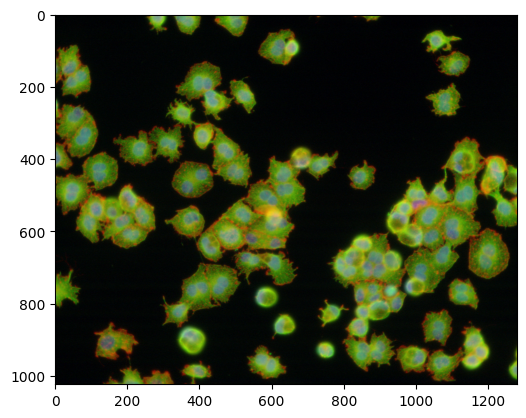

In [55]:
plt.imshow(images['Week1_22123_1_11'])

In [76]:
metadata_large_fov = {"SAMPLE_KEY": [],
                        "BATCH" : [],
                        "TABLE_NUMBER" : [],
                        "IMAGE_NUMBER" : [],
                        "OBJECT_NUMBER" : [],
                        "CPD_NAME" : [],
                        "SMILES" : [],
                        "DOSE" : [],
                        "ANNOT": [],
                        "STATE" : []}

for img_file in tqdm(images):
    img = images[img_file]
    img = (transform.resize(img, (1024, 1024)) * 255.).astype(np.uint8)
    patch_array = split_image_array_into_patches(img, 512)
    # Derive the specific information about the image 
    week, plate, table, obj_no = img_file.split("_")
    metadata_plate = dataframe.loc[(dataframe.BATCH==f"{week}_{plate}") & (dataframe.TABLE_NUMBER==int(table))& (dataframe.IMAGE_NUMBER==int(obj_no))]
    for i in range(len(patch_array)):
        try :
            path_array_i = patch_array[i]
            SAMPLE_KEY = f"{img_file}_{i}"
            BATCH = f"{week}_{plate}"
            TABLE_NUMBER = table
            IMAGE_NUMBER = obj_no
            OBJECT_NUMBER = i
            CPD_NAME = np.unique(metadata_plate.CPD_NAME)[0]
            SMILES = np.unique(metadata_plate.SMILES)[0]
            DOSE = np.unique(metadata_plate.DOSE)[0]
            ANNOT = np.unique(metadata_plate.ANNOT)[0]
            STATE = np.unique(metadata_plate.STATE)[0]
            metadata_large_fov["SAMPLE_KEY"].append(SAMPLE_KEY)
            metadata_large_fov["BATCH"].append(BATCH)	
            metadata_large_fov["TABLE_NUMBER"].append(TABLE_NUMBER)	
            metadata_large_fov["IMAGE_NUMBER"].append(IMAGE_NUMBER)	
            metadata_large_fov["OBJECT_NUMBER"].append(OBJECT_NUMBER)	
            metadata_large_fov["CPD_NAME"].append(CPD_NAME)	
            metadata_large_fov["SMILES"].append(SMILES)	
            metadata_large_fov["DOSE"].append(DOSE)	
            metadata_large_fov["ANNOT"].append(ANNOT)	
            metadata_large_fov["STATE"].append(STATE)	
            path = dataset_path / week / plate 
            
            # Resize and save images from the array 
            image_to_save = patch_array[i]
            image_to_save = (transform.resize(image_to_save, (128, 128)) * 255.).astype(np.uint8)
            
            path_to_img = path / f"{table}_{IMAGE_NUMBER}_{OBJECT_NUMBER}.npy"
            path.mkdir(parents=True, exist_ok=True)
            np.save(path_to_img, image_to_save)
        except:
            continue


100%|██████████| 2528/2528 [15:03<00:00,  2.80it/s]


In [77]:
metadata_large_df = pd.DataFrame(metadata_large_fov)

In [92]:
np.random.seed(42)
split_ratio = 0.8
split_column = np.random.choice(['train', 'test'], size=len(metadata_large_df), p=[split_ratio, 1 - split_ratio])
metadata_large_df['SPLIT'] = split_column

In [93]:
metadata_large_df.to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all_large/metadata/bbbc021_large.csv")

In [90]:
# df_bbbc021_large = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all_large/metadata/bbbc021_large.csv")

In [91]:
# for i in df_bbbc021_large.SAMPLE_KEY:
#     week, plate, table, image, obj = i.split("_")
#     img = np.load(dataset_path / week / plate / f"{table}_{image}_{obj}.npy")
#     assert img.shape == (128, 128, 3)